# [ LG에너지솔루션 DX Expert 양성과정  ] 시계열 데이터 분석을 위한 딥러닝

## CNN 기반의 시계열 데이터 분석

### 강의 복습
강의자료 : 시계열 분석을 위한 딥러닝, 01 CNN 기반의 시계열 데이터 분석

- 합성곱 신경망 Convolutional Neural Network(CNN) : 합성곱 연산을 통해 이미지로부터 필요한 특질을 스스로 학습할 수 있는 능력을 갖춘 심층 신경망 구조
- 1-D Convolution : 시계열 데이터는 이미지 데이터와는 달리 변수들 사이의 Spatial Correlation이 존재하지 않는다. 1-D Convolution은 모든 변수를 한번에 고려하여 시간 축에 대해서만 Convolution 연산을 수행한다.
- 시계열 예측 : 일부 기간 데이터를 입력으로 하여 이후 기간 데이터를 예측

<img src="./image/TCN02.png" width="900">

<img src="./image/TCN03.png" width="900">

### 실습 요약
1. 본 실습에서는 CNN 기반으로 하는 TCN 모델을 활용하여 시계열 예측 모델을 구축합니다.
2. 시계열 데이터에 적용할 수 있는 convolutional layer인 1D CNN과 긴 길이의 시계열 데이터를 효율적으로 처리할 수 있는 Dialted Convolution을 적용한 Temporal Convolutional Network(TCN)에 대해서 알아봅니다.

---

### STEP 0. 환경 구축하기

- 필요한 library들을 import 합니다.

In [1]:
!pip install torchinfo

In [2]:
import os
import time
import sys
from urllib import request
import zipfile
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils import weight_norm
from torchinfo import summary

import warnings
warnings.filterwarnings("ignore")

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.6.9 (default, Dec  8 2021, 21:08:43) 
[GCC 8.4.0]].
PyTorch version:[1.7.1].
device:[cuda:0].


In [3]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기

금일 실습에서는 Jena Climate 데이터를 활용하여 시계열 예측을 진행합니다.

- Dataset : Jena Climate
- Info :
    - Max Planck 생지화학 연구소가 기록
    - 14가지 features(온도, 압력, 습도 등)
    - 10분당 1회 기록
    - Location : Weather Station, Max Planck Instiute for Biogeochemistry in Jena, Germany
    - Time-frame Considered: Jan 10, 2009 - December 31, 2016

|Index|Features|Format|Description|
|----|----|----|:----|
|1|Date Time|01.01.2009 00:10:00|Date-time reference|
|2|p (mbar)|996.52|The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.|
|3|T (degC)|-8.02|Temperature in Celsius|
|4|Tpot (K)|265.4|Temperature in Kelvin|
|5|Tdew (degC)|-8.9|Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.|
|6|rh (%)|93.3|Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.|
|7|VPmax (mbar)|3.33|Saturation vapor pressure|
|8|VPact (mbar)|3.11|Vapor pressure|
|9|VPdef (mbar)|0.22|Vapor pressure deficit|
|10|sh (g/kg)|1.94|Specific humidity|
|11|H2OC (mmol/mol)|3.12|Water vapor concentration|
|12|rho (g/m ** 3)|1307.75|Airtight|
|13|wv (m/s)|1.03|Wind speed|
|14|max. wv (m/s)|1.75|Maximum wind speed|
|15|wd (deg)|152.3|Wind direction in degrees|

In [4]:
# 데이터셋 다운
annotation_folder = os.path.abspath(".") + "/data/"
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
savefile = os.path.join(annotation_folder, os.path.basename(url))

if not os.path.exists(annotation_folder):
    os.makedirs(annotation_folder)
    print('Folder creation complete!')
else:
    print('The folder already exists.')

if not os.path.isfile(savefile):
    request.urlretrieve(url, savefile)
    with zipfile.ZipFile(savefile, 'r') as zip_ref:
        zip_ref.extractall(annotation_folder)
    print('File creation complete!')
else:
    print('The File already exists.')

# 데이터셋 불러오기
df = pd.read_csv(savefile)

The folder already exists.
The File already exists.


In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### STEP 2. 데이터 시각화

작업 중인 데이터에 대한 이해를 돕기 위해 각 기능을 아래에 도표로 표시합니다. 이는 2009년부터 2016년까지의 기간 동안 각 특징의 뚜렷한 패턴을 보여줍니다. 또한 정규화 과정에서 해결될 이상 징후가 있는 곳도 보여줍니다.

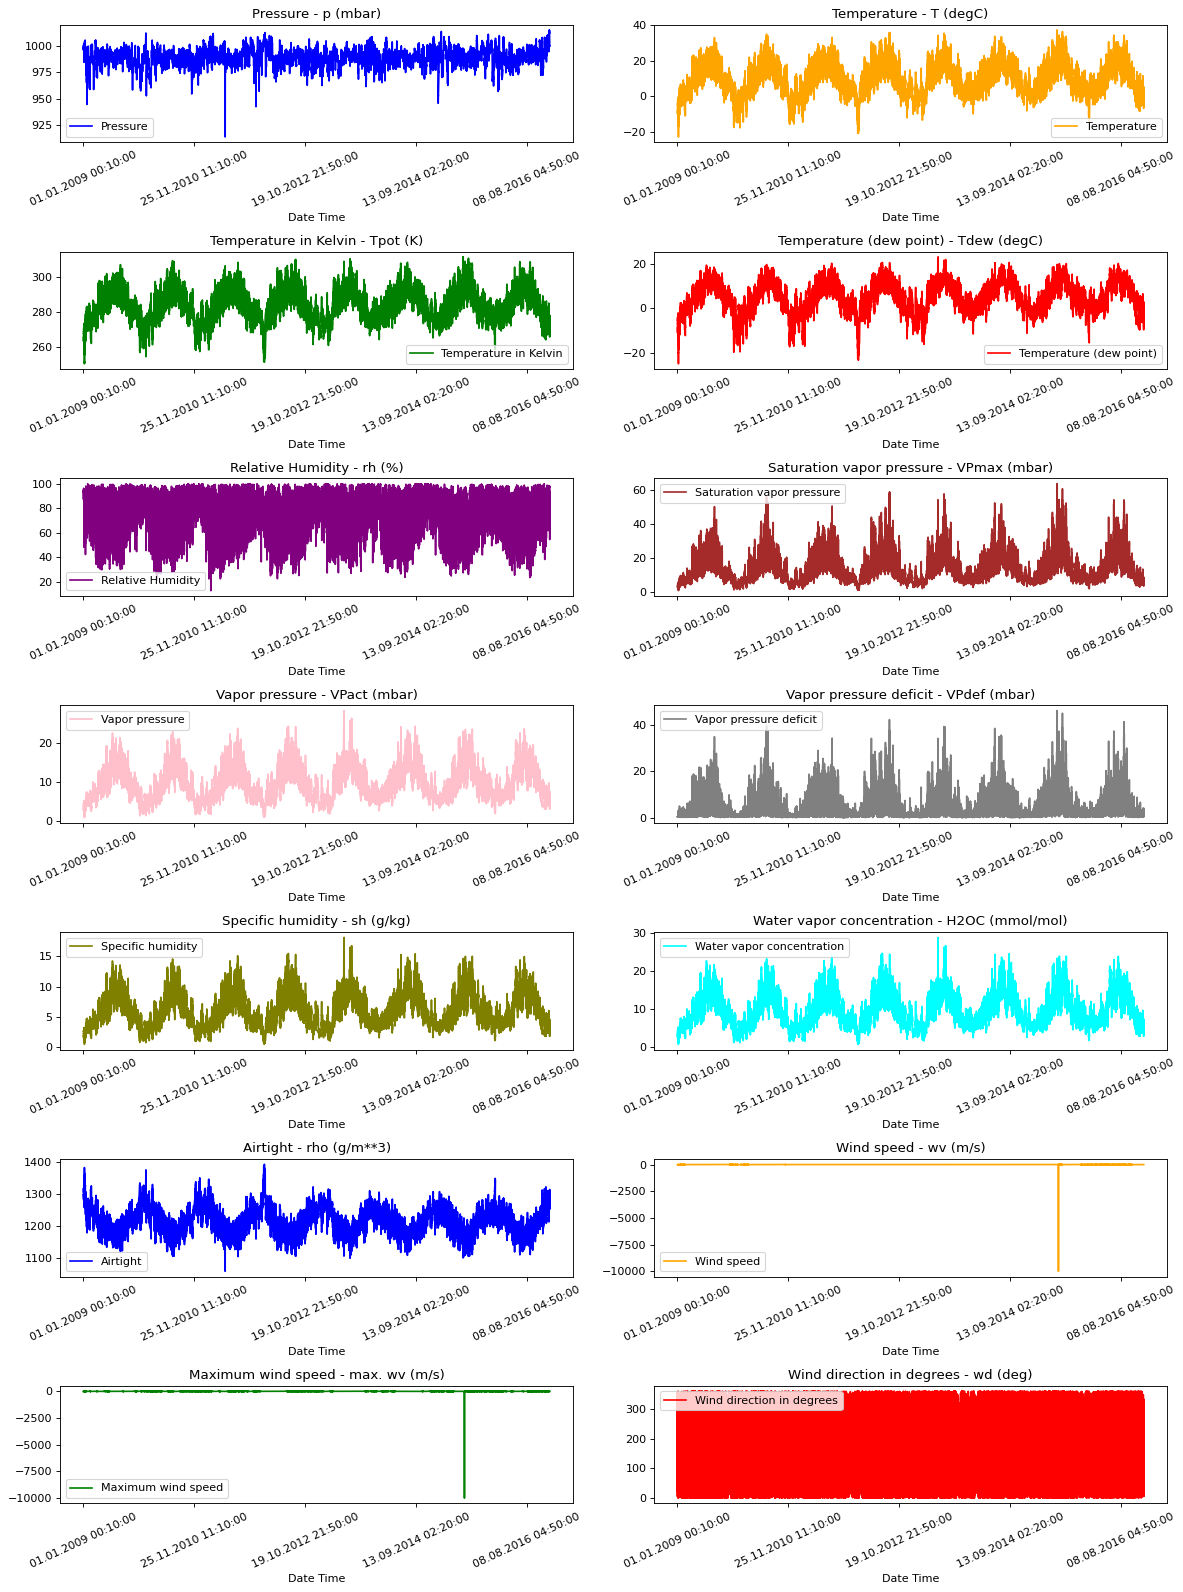

In [6]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"

# raw 데이터 시각화
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        t_data = data[key]
        t_data.index = time_data
        c = colors[i % (len(colors))]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

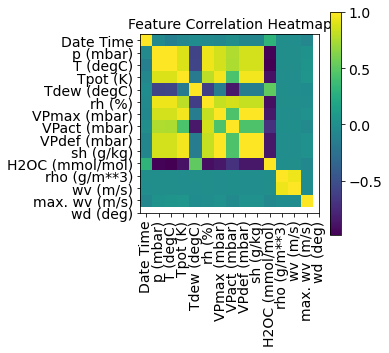

In [7]:
# 변수 간 상관관계 히트맵 시각화
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

### STEP 3. 데이터 전처리

- Train, Valid 비율 : 0.715 & 0.285
- 과거 720개의 timestamp(720/6=120시간)의 데이터를 input으로 하고, 72개의 timestamp(72/6=12시간) 이후의 온도를 예측
- [0, 1]로 정규화 (MinMax)

In [8]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

params = {
    'input_size': 7,
    'output_size': 1,
    'num_channels': [32],
    'output_length': 1,
    'kernel_size': 2,
    'dropout': 0.2
          }

In [9]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]

# train 데이터를 기반으로 train/test 데이터에 대하여 minmax scaling 적용
scaler = MinMaxScaler().fit(features)
features = scaler.transform(features)
features = pd.DataFrame(features)

train_data = features.loc[0:train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [10]:
print(f'length of train dataset: {len(train_data)}, length of validation dataset: {len(val_data)}')

length of train dataset: 300693, length of validation dataset: 119858


In [11]:
start = past + future   # 720 + 72 = 792
end = start + train_split   # 792 + 300693 = 301485

x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)  # 720 / 6 = 120

In [12]:
x_end = len(val_data) - past - future   # 119858 - 720 - 72 = 119066

label_start = train_split + past + future   # 300693 + 720 + 72 = 301485

x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:][[1]]

In [13]:
y_train

,1
792,0.141815
793,0.148117
794,0.156742
795,0.163045
796,0.175651
...,...
301480,0.574059
301481,0.565268
301482,0.572898
301483,0.578869


In [14]:
print(f'shape of X : {x_train.shape}, shape of y : {y_train.shape}')

shape of X : (300693, 7), shape of y : (300693, 1)


In [15]:
class CustomDataset(Dataset):
    def __init__(self, X, y, sequence_length=120, step=6, stride=1):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        self.step = step
        self.stride = stride

        self.valid_idxs = [i for i in range(0, len(X)-self.sequence_length*self.step+1)]
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]

    def __len__(self):
        return len(self.valid_idxs)

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + self.sequence_length*self.step
        input_sequence = np.array(self.X[i:last:self.step], dtype=np.float32)
        target = np.array(self.y.iloc[i], dtype=np.float32)
        return torch.from_numpy(input_sequence), torch.from_numpy(target)

In [16]:
DataLoader_params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0,
          'pin_memory' : True
         }

train_dataset = CustomDataset(x_train, y_train, sequence_length, step)
val_dataset = CustomDataset(x_val, y_val, sequence_length, step)
train_loader = DataLoader(dataset=train_dataset, **DataLoader_params)
DataLoader_params['shuffle'] = False
val_loader = DataLoader(dataset=val_dataset, **DataLoader_params)

In [17]:
print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)

torch.Size([256, 120, 7]) torch.Size([256, 1])


In [18]:
input_shape = next(iter(train_loader))[0].shape

### SETP 4. 모델 (TCN)

![TCN01.png](./image/TCN01.png)

![TCN01.png](./image/TCN04.png)

#### Causal Convolution

- Causal convolution은 시간에 따른 의존성을 고려하며, 현재 시점의 출력이 과거의 입력에만 의존하도록 보장
- 과거의 정보만을 사용하여 현재를 예측하므로, 미래의 정보가 현재의 예측에 영향을 주지 않습니다. 
- 모델이 시퀀스 내의 시간적 순서를 올바르게 학습

In [19]:
# Causal Convolution을 위한 padding
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# TCN을 구성하는 base가 되는 block 구성 (1-D dilated causal conv + residual)
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

# TCN
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [20]:
# 시계열 예측을 위한 모델 구성 (TCN + Linear)
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, output_length, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.output_length = output_length

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x.transpose(1, 2)).transpose(1, 2)
        output = output[:, -self.output_length, :]
        output = self.linear(output)
        return output

In [21]:
model = TCN(**params).to(device)

In [22]:
model

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(7, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(7, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(7, 32, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)

In [23]:
summary(model, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
TCN                                      --                        --
├─TemporalConvNet: 1-1                   [256, 32, 120]            --
│    └─Sequential: 2-1                   [256, 32, 120]            --
│    │    └─TemporalBlock: 3-1           [256, 32, 120]            2,880
├─Linear: 1-2                            [256, 1]                  33
Total params: 2,913
Trainable params: 2,913
Non-trainable params: 0
Total mult-adds (M): 53.78
Input size (MB): 0.86
Forward/backward pass size (MB): 23.73
Params size (MB): 0.01
Estimated Total Size (MB): 24.60

In [24]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [26]:
'''
학습 코드 (한번의 epoch)
'''
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None, progress_display=False):
    # 학습에 소요된 시간, loss 기록 및 출력
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    progress = ProgressMeter(
        len(train_data),
        [batch_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    # 모델 학습 시작
    model.train()
    end = time.time()
    for idx, [X, y] in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)

        inputs = X.to(device).float()
        targets = y.to(device).float()

        predictions = model(inputs)
        train_loss = loss_fn(predictions, targets)

        train_loss.backward()
        optimizer.step()

        losses.update(train_loss.item(), inputs.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if progress_display == True and idx % 50 == 0:
            progress.display(idx)

    return losses.avg

In [27]:
'''
검증 코드 (한번의 epoch)
'''
def validation(model, val_data, loss_fn):
    losses = AverageMeter('Loss', ':.4e')
    model.eval()
    for idx, [X, y] in enumerate(val_data):
        inputs = X.to(device).float()
        targets = y.to(device).float()
        with torch.no_grad():
            predictions = model(inputs)
            val_loss = loss_fn(predictions, targets)
        losses.update(val_loss.item(), inputs.size(0))

    return losses.avg

In [28]:
'''
Early Stopping
머신러닝에서 과적합(overfitting)을 방지하기 위한 기법 중 하나입니다.
학습 과정에서 검증 데이터셋에 대한 모델의 성능이 개선되지 않을 때, 즉 오차가 더 이상 줄어들지 않거나 증가하기 시작할 때 학습을 중단하는 것을 말합니다. 
'''
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [29]:
%%time
best = {"loss": sys.float_info.max}
history = dict()
early_stopping = EarlyStopping(patience=5, verbose=1)

'''
여러번 EPOCH을 통해 학습 진행하기
'''
for epoch in range(1, epochs+1):
    epoch_loss = train(model, train_loader, optimizer, loss_fn)
    val_loss = validation(model, val_loader, loss_fn)

    history.setdefault('loss', []).append(epoch_loss)
    history.setdefault('val_loss', []).append(val_loss)

    print(f"[Train] Epoch : {epoch:^3}"
          f"  Train Loss: {epoch_loss:.4}"
          f"  Valid Loss: {val_loss:.4}")

    if val_loss > best["loss"]:
        best["state"] = seg.state_dict()
        best["epoch"] = epoch
    if early_stopping.validate(val_loss):
        break

[Train] Epoch :  1   Train Loss: 0.01164  Valid Loss: 0.005693
[Train] Epoch :  2   Train Loss: 0.005794  Valid Loss: 0.005629
[Train] Epoch :  3   Train Loss: 0.005618  Valid Loss: 0.005591
[Train] Epoch :  4   Train Loss: 0.005489  Valid Loss: 0.005642
[Train] Epoch :  5   Train Loss: 0.005355  Valid Loss: 0.005344
[Train] Epoch :  6   Train Loss: 0.005232  Valid Loss: 0.005353
[Train] Epoch :  7   Train Loss: 0.005111  Valid Loss: 0.005231
[Train] Epoch :  8   Train Loss: 0.005037  Valid Loss: 0.005038
[Train] Epoch :  9   Train Loss: 0.005  Valid Loss: 0.00498
[Train] Epoch : 10   Train Loss: 0.004971  Valid Loss: 0.005025
CPU times: user 48min 44s, sys: 2.7 s, total: 48min 47s
Wall time: 11min 16s


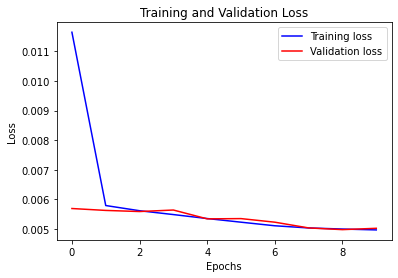

In [30]:
# loss 변화 추이 확인
def visualize_loss(history, title):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

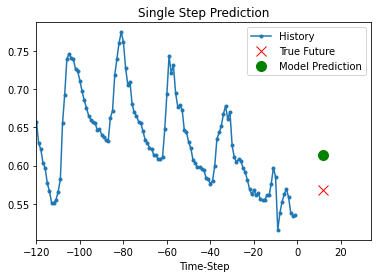

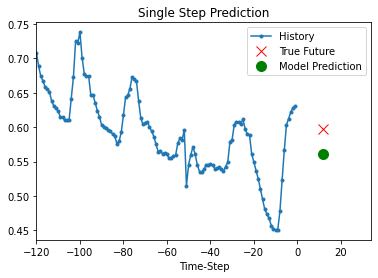

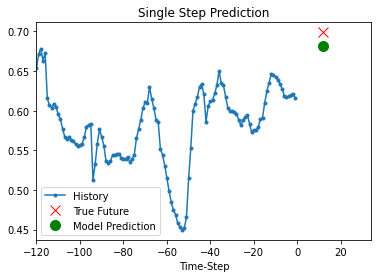

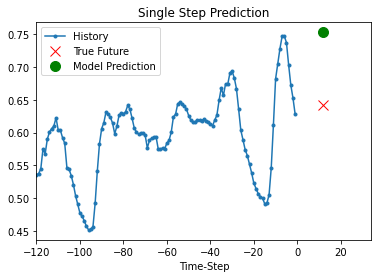

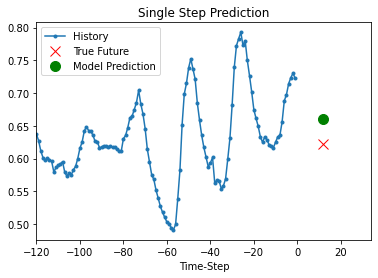

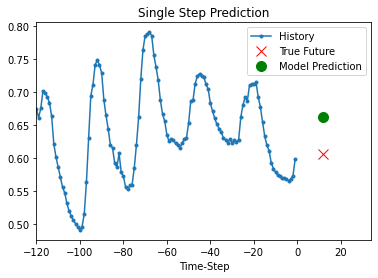

In [31]:
# 이전 시계열과 실제 target 값, 그리고 모델이 예측한 값을 비교해봅시다.
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for i, (X, y) in enumerate(val_loader):
    if i > 5:
        break
    else:
        inputs = torch.unsqueeze(X[0], 0).to(device).float()
        outputs = model(inputs).cpu().detach().numpy()
        show_plot(
            [X[0][:, 1].numpy(), y[0].numpy(), outputs],
            12,
            "Single Step Prediction",
        )

---